In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn, os

from mpl_toolkits import mplot3d

/home/yloukachev/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}

ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

In [3]:
merged_dataset = xr.merge([ds[name][name] for name in ds.keys()])
df = merged_dataset.to_dataframe().reset_index()

df.dropna(subset=['xlon', 'ylat','pCO2', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl'], inplace=True)
shift_param = int(df.shape[0]/df['time'].nunique())

df['A'], df['B'], df['C'] = np.sin(df['ylat']), np.sin(df['xlon'])*np.cos(df['ylat']), -np.cos(df['xlon'])*np.cos(df['ylat'])
df['T0'] = np.cos(df.time.dt.dayofyear * 2 * np.pi/365)
df['T1'] = np.sin(df.time.dt.dayofyear * 2 * np.pi/365)

df.drop(columns=['xlon', 'ylat', 'time', 'TLONG', 'TLAT'], inplace=True)

df['pCO2'] = df.pop('pCO2')
df.head()

,XCO2,SST,SSS,MLD,Chl,A,B,C,T0,T1,pCO2
20,340.848541,-1.552322,33.641834,12.729663,1.128493,-0.375524,0.444338,-0.813355,0.962309,0.271958,256.390077
21,340.848541,-1.626047,33.667816,19.951666,0.900315,0.576990,0.391571,-0.716767,0.962309,0.271958,262.338616
22,340.848541,-1.607591,33.572289,19.510101,0.635458,0.999021,-0.021204,0.038813,0.962309,0.271958,261.956626
23,340.848541,-1.496069,33.424641,20.714338,0.420227,0.502557,-0.414484,0.758709,0.962309,0.271958,262.739347
24,340.848541,-1.207762,33.317802,20.579535,0.380468,-0.455956,-0.426690,0.781051,0.962309,0.271958,266.288585


In [4]:
values = df.values
n_train_months = shift_param * 12 * 30 # training on 30 years and evaluating on five years

train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14785200, 10) (14785200,) (2505270, 10) (2505270,)


## Baseline Feedforward Neural Network

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, kernel_initializer='normal')])

model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mse'])

In [7]:
history = model.fit(train_X, train_y, epochs=100, batch_size=1024, validation_data=(test_X, test_y))

Train on 14785200 samples, validate on 2505270 samples
Epoch 1/100
14785200/14785200 [==============================] - 120s 8us/step - loss: 861.8007 - mean_squared_error: 861.8007 - val_loss: 732.2238 - val_mean_squared_error: 732.2238
Epoch 2/100
14785200/14785200 [==============================] - 119s 8us/step - loss: 645.5460 - mean_squared_error: 645.5460 - val_loss: 628.1847 - val_mean_squared_error: 628.1847
Epoch 3/100
14785200/14785200 [==============================] - 121s 8us/step - loss: 559.8103 - mean_squared_error: 559.8103 - val_loss: 573.5782 - val_mean_squared_error: 573.5782
Epoch 4/100
14785200/14785200 [==============================] - 120s 8us/step - loss: 499.6409 - mean_squared_error: 499.6409 - val_loss: 537.3167 - val_mean_squared_error: 537.3167
Epoch 5/100
14785200/14785200 [==============================] - 120s 8us/step - loss: 469.0201 - mean_squared_error: 469.0201 - val_loss: 517.5426 - val_mean_squared_error: 517.5426
Epoch 6/100
14785200/14785200 

14785200/14785200 [==============================] - 118s 8us/step - loss: 292.5567 - mean_squared_error: 292.5567 - val_loss: 331.3230 - val_mean_squared_error: 331.3230
Epoch 46/100
14785200/14785200 [==============================] - 116s 8us/step - loss: 291.9862 - mean_squared_error: 291.9862 - val_loss: 347.6072 - val_mean_squared_error: 347.6072
Epoch 47/100
14785200/14785200 [==============================] - 116s 8us/step - loss: 291.2407 - mean_squared_error: 291.2407 - val_loss: 324.4181 - val_mean_squared_error: 324.4181
Epoch 48/100
14785200/14785200 [==============================] - 117s 8us/step - loss: 290.7258 - mean_squared_error: 290.7258 - val_loss: 338.5935 - val_mean_squared_error: 338.5935
Epoch 49/100
14785200/14785200 [==============================] - 116s 8us/step - loss: 290.1006 - mean_squared_error: 290.1006 - val_loss: 335.4159 - val_mean_squared_error: 335.4159
Epoch 50/100
14785200/14785200 [==============================] - 117s 8us/step - loss: 289.3

14785200/14785200 [==============================] - 118s 8us/step - loss: 275.4299 - mean_squared_error: 275.4299 - val_loss: 329.0726 - val_mean_squared_error: 329.0726
Epoch 90/100
14785200/14785200 [==============================] - 117s 8us/step - loss: 275.1164 - mean_squared_error: 275.1164 - val_loss: 354.2044 - val_mean_squared_error: 354.2044
Epoch 91/100
14785200/14785200 [==============================] - 117s 8us/step - loss: 275.0030 - mean_squared_error: 275.0030 - val_loss: 348.5294 - val_mean_squared_error: 348.5294
Epoch 92/100
14785200/14785200 [==============================] - 117s 8us/step - loss: 274.9372 - mean_squared_error: 274.9372 - val_loss: 341.1953 - val_mean_squared_error: 341.1953
Epoch 93/100
14785200/14785200 [==============================] - 117s 8us/step - loss: 274.7636 - mean_squared_error: 274.7636 - val_loss: 325.9420 - val_mean_squared_error: 325.9420
Epoch 94/100
14785200/14785200 [==============================] - 116s 8us/step - loss: 274.6

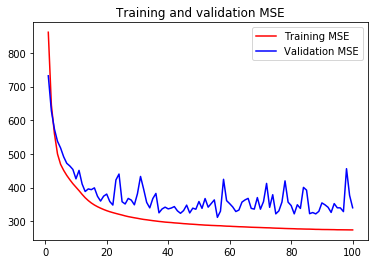

In [8]:
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

epochs = range(1, len(mse) + 1)

plt.figure()
plt.plot(epochs, mse, 'r', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()

plt.show()

In [11]:
model.save_weights('baseline_DNN.h5')